<H1 align="center">Guiding question: What topics exist in these tweets?</H1>
<H2 align="center">author: Brian Lehman</H2>

# Introduction
Tinkering with some [old tweet data](https://github.com/DrSkippy/Data-Science-45min-Intros/tree/master/topic-modeling-201) that was gathered while the author worked at Gnip, context is provided for a brief consideration of the author's python + viz skill.  


## Process
Topic modeling goes from a big mess, to organizational beauty via interesting math, then back to a big mess of subjective interpretations peppered with various levels of credibility. The attempt here is to gain some mastery over this credibility factor. Included below is an overview of this project's topic discovery process follows:

1. Setting up the environment
2. Loading the Data
3. Exploring the data
4. Pre-processing the data
5. Exploring topic modeling methods
6. Building a baseline LDA model
7. Determining a standard metric for evaluation
8. Evaluating the LDA model 
9. Comparing the baseline model to a CorEx model
10. Visualizing the results
11. Discussing what we can learn from the results
12. Exploring next steps


### Virtual Environment
The env is available in the `environment.yml` and was output in this way via command line:

* `conda env export --from-history > environment.yml`.

See [creating-an-environment-from-an-environment-yml-file](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) on Conda's site to load the environment. 

Side note: adding conda-forge to channels seems helpful. 
* `conda config --add channels conda-forge`
* `conda config --set channel_priority strict`
  
### kernel
After activating the conda environment, make the kernel accessible (see [stackoverflow](https://stackoverflow.com/a/44786736)):
* `python -m ipykernel install --user --name tweet_topic_modeling --display-name "tweet_topic_modeling"`

### IDE
Jupyter Lab is used and the "tweet_topic_modeling" kernel is selected. 

* `jupyter lab`
 
### Pip

After activating the env, the author uses `pip` to install a few libs:

* `python -m pip install langid langdetect torch gensim huggingface-hub langdetect langid nodejs pyLDAvis seaborn wordcloud nltk corextopic`

### Pytest 
A test suit is used to confirm changes to the code base do not break anything critical. The test can be run from the command line:

* `cd tweet_topic_modeling`
* `python -m pytest`
  
## Data Source
Post Elon, the site formerly known as Twitter no longer makes tweet data freely available. This original data set arrives from one of the author's topic modeling projects from 2015 (see [topic-modeling-201](https://github.com/DrSkippy/Data-Science-45min-Intros/tree/master/topic-modeling-201) repo). The data contains 5,000 tweets using the search term "golden retriever" that was freely snagged from Twitter's public API. 

### Data Issue & Implemented Solution

* issue: Less than 10% of the original tweet's text are unique; over 80% of the original tweets' text contains "**half pitbull half goden retriever**".
* solution: (accomplished below) over 50% uniqueness is obtained using some text replacement detailed in the Apple DataViz Team Special Edition section.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%capture output
import pickle as pkl
with open('data/tweet_text.pkl', 'rb') as file:
    tweet_text = pkl.load(file)

In [3]:
import random
random.sample(tweet_text,40)

['RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @Goals4Dudes: Half pitbull half golden retriever https://t.co/MNf647Tr6r',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @Fascinatingpics: This Golden Retriever Snuggling With His Bird And Hamster \n\n7 pics here: https://t.co/teRbt9X5yE\n\n. https://t.co/0gYJ1…',
 'RT @Goals4Dudes: Half pitbull half golden retriever https://t.co/MNf647Tr6r',
 'RT @HighSchoolSuckz: Some days I wish I was a Golden Retriever in an upper class family.',
 'RT @Goals4Dudes: Half pitbull half golden retriever https://t.co/MNf647Tr6r',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half

In [4]:
from collections import Counter
print("-------------ORIGINAL TWEET SET: MOST COMMON TWEETS-------------")
Counter(tweet_text).most_common(5)

-------------ORIGINAL TWEET SET: MOST COMMON TWEETS-------------


[('RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
  1824),
 ('RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
  1387),
 ('RT @Goals4Dudes: Half pitbull half golden retriever https://t.co/MNf647Tr6r',
  672),
 ('RT @Fascinatingpics: This Golden Retriever Snuggling With His Bird And Hamster \n\n7 pics here: https://t.co/teRbt9X5yE\n\n. https://t.co/0gYJ1…',
  95),
 ('RT @RetrieverPics: half pitbull half golden retriever https://t.co/q3wkO6mbtZ',
  60)]

In [5]:
import re
# Count the number of tweets containing the phrase "half pitbull half golden retriever"
count = sum(1 for tweet in tweet_text if re.search(r'half\s+pitbull\s+half\s+golden\s+retriever', tweet, flags=re.IGNORECASE))

# Output the count
print(f"Tweets containing 'half pitbull half golden retriever': {count}/5000 (>80%)")

Tweets containing 'half pitbull half golden retriever': 4147/5000 (>80%)


In [6]:
print(f'percent of original tweets unique: {100*len(set(tweet_text))/len(tweet_text)}%')

percent of original tweets unique: 8.96%


## **Apple DataViz Team Special Edition** (for funsies) 
Since most of these tweets contain the term "half pitbull half golden retriever," some Tom Robbins style whimsy along the names of Apple's legendary DataViz teammates are selected with some randomness to build a new corpus. See `data_processing.py` for full details. 

In [7]:
from data.utils.data_processing import process_tweets
from models.viz.utils import get_replaced_tweets
import random
import joblib
import datetime 

time_created = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run = False
if run: 
    replaced_tweets = process_tweets(tweet_text)
    joblib.dump(replaced_tweets, 'data/whimsy_tweets.joblib')
    joblib.dump(replaced_tweets, f'data/whimsy_tweets_{time_created}.joblib')
else:
    replaced_tweets = get_replaced_tweets()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/altair/utils/schemapi.py:353: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature request (on referencing) if you are missing an API for the kind of customization you need.
  resolver = jsonschema.RefResolver.from_schema(root or schema)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/altair/utils/schemapi.py:353: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a featu

In [8]:
print("-------------> NEW APPLE DATAVIZ TEAM TWEET SET <-------------")
### show updated tweet set
for tweet in random.sample(replaced_tweets, 5): 
    print(tweet)

-------------> NEW APPLE DATAVIZ TEAM TWEET SET <-------------
RT @PitbuIIs: half resplendent gazelle disco dancing with penguins, half Adila https://t.co/5Q8blK2MHR
RT @PitbuIIs: half peculiar gargoyle juggling comets, half Sesh https://t.co/5Q8blK2MHR
RT @PitbuIIs: half enchanting shooting star riding unicorns with a friendly ferret, half Sesh https://t.co/5Q8blK2MHR
RT @PitbuIIs: half fantastical gargoyle blowing kisses to auroras, half Sesh https://t.co/5Q8blK2MHR
RT @kayipkopek: #İstanbul #Güngören 5 yaşında Erkek Sesh Pascal Kayıp! İletişim: 05358867941  https://t.co/8AFpXiQJ0q https://t…


In [9]:
print(f'percent of replaced tweets unique: {100*len(set(replaced_tweets))/len(replaced_tweets)}%') 

percent of replaced tweets unique: 54.52%


In [10]:
from collections import Counter
print("-------------UPDATED TWEET SET: MOST COMMON TWEETS-------------)")
Counter(replaced_tweets).most_common(5)

-------------UPDATED TWEET SET: MOST COMMON TWEETS-------------)


[('RT @Fascinatingpics: This Adila Snuggling With His Bird And Hamster \n\n7 pics here: https://t.co/teRbt9X5yE\n\n. https://t.co/0gYJ1…',
  42),
 ('RT @kayipkopek: #İstanbul #Kadıköy 8-10 yaşında Dişi Golden Zeyna Kayıp! İletişim:05072421903 @aysertunaisil https://t.co/DqTrKkWJpb https:…',
  36),
 ('RT @Fascinatingpics: This Patrick Snuggling With His Bird And Hamster \n\n7 pics here: https://t.co/teRbt9X5yE\n\n. https://t.co/0gYJ1…',
  30),
 ('RT @Fascinatingpics: This Sesh Snuggling With His Bird And Hamster \n\n7 pics here: https://t.co/teRbt9X5yE\n\n. https://t.co/0gYJ1…',
  23),
 ('RT @HighSchoolSuckz: Some days I wish I was a Adila in an upper class family.',
  17)]

### Initial thoughts on data decision & ideas to explore
1. The data edit for the Apple DataViz Team is fire! The author cannot read these tweets without laughing. 
3. The RT in the text is an outdated way of establishing that a tweet is actually a retweet; remove it; not relevant to the topcs. 
4. In the first 10 tweets viewed, 8 had links, but only 1 link went to a non-suspended user.
    * What should we do with links in general?
        * note: following links can provide context and might be interesting; however, this is too much extra work for this project.
        * decision: focus purely on the text and remove the links.
5. The @ mentions should be removed to clean the text; not relevant to topics.  
6. Punctuation could be removed to clean the text; however, certain tools make use of punctuation for context. 
7. Stemming might be useful to test its affects the coherence scores. 
8. If "half" shows up as significantly weighted in the topics, the word "half" might be added to the stopwords list.
9. Build a baseline model to which we can compare our improvements. 


#### run once
Just getting a quick house keeping project out of the way.

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lehman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lehman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Part I: Exploratory Analysis 
### Quick LDA Modeling scratch work
The scratch work done here is mostly to tinker with parameters and just get a feel for how the LDA process works. 
* "half" is added to stopwords, which makes the tweet text read oddly when printed below. 
* topics are printed
* sample tweets with topic probability are shown
* a coherence score is calculated using `c_v` and `u_mass` respectively.
* mapping from the pre-processed and uniqued tweets back to the original offered insight into the one to many relationship.

In [12]:
from models import LDA_m3
from models.viz.utils import get_replaced_tweets
from models.viz.utils import print_results
print_results(*LDA_m3.main(get_replaced_tweets()))

Initial tweets: 5000
Unique tweets: 1211
Training tweets: 787
Test tweets: 424
Total topics: 3

Topics and their meanings:
Topic 0: 0.092*"sesh" + 0.039*"adila" + 0.021*"hamster" + 0.019*"dressed" + 0.019*"sailing" + 0.019*"across" + 0.019*"tux" + 0.019*"atlantic" + 0.019*"blowing" + 0.019*"kisses"
Topic 1: 0.076*"patrick" + 0.025*"adila" + 0.023*"baby" + 0.022*"thunderbolts" + 0.022*"trading" + 0.022*"otter" + 0.022*"manifesting" + 0.021*"trash" + 0.021*"sea" + 0.021*"swimming"
Topic 2: 0.052*"adila" + 0.048*"patrick" + 0.023*"dogs" + 0.022*"playing" + 0.021*"love" + 0.021*"ghosts" + 0.021*"prairie" + 0.021*"pattycake" + 0.020*"moon" + 0.020*"singing"
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) en

In [13]:
%%time 
from models.LDA_m3 import create_mapping
from models.viz.utils import get_replaced_tweets
lda_model, tweet_texts, num_topics, unique_tweet_texts, train_texts, train_tokens, test_texts, dictionary, test_corpus, train_corpus = LDA_m3.main(get_replaced_tweets())

CPU times: user 23 s, sys: 2.23 s, total: 25.2 s
Wall time: 6.75 s


In [14]:
%%time
mapping = create_mapping(unique_tweet_texts, tweet_texts)

CPU times: user 704 ms, sys: 43.9 ms, total: 748 ms
Wall time: 749 ms


In [15]:
print("-------------------------------------------------------------")
print("5 ORIGINAL tweets with their topic label and probability:")
print("-------------------------------------------------------------")
for i, doc in enumerate(random.sample(test_corpus, 5)):
    
    print(f"ORIGINAL tweet: {mapping[unique_tweet_texts[i]]}")
    topic_distribution = lda_model.get_document_topics(doc)
    for topic, proba in topic_distribution:
        print(f"Topic label: {topic} Probability:{proba}")
    print("-------------------------------------------------------------")
    print("")

-------------------------------------------------------------
5 ORIGINAL tweets with their topic label and probability:
-------------------------------------------------------------
ORIGINAL tweet: ['RT @BabyAnimalPics: half ethereal cloud spelling words in the sky with fireflies, half Adila https://t.co/86vpNGZ9mr', 'RT @Goals4Dudes: half ethereal cloud spelling words in the sky with fireflies, half Adila https://t.co/MNf647Tr6r', 'RT @PitbuIIs: half ethereal cloud spelling words in the sky with fireflies, half Adila https://t.co/5Q8blK2MHR', 'RT @PitbuIIs: half ethereal cloud spelling words in the sky with fireflies, half Adila https://t.co/5Q8blK2MHR']
Topic label: 0 Probability:0.010610480792820454
Topic label: 1 Probability:0.1600833237171173
Topic label: 2 Probability:0.8293061852455139
-------------------------------------------------------------

ORIGINAL tweet: ['RT @BabyAnimalPics: half magnificent volcano singing love songs to the moon, half Sesh https://t.co/86vpNGZ9mr', 'R

### Thoughts on output 
1. What size is this dataset after pre-processing and uniquing?
   * 5000 original tweets to 1335 unique tweets seems surprisingly small.
   * note: the mapping above explains it. The one to many mapping happens after we pre-process the text. 
1. Are the topics very distinct? Meaning, are the probabilities for the tweets predicting one clear winner or are the probabilities roughly equal across all topics?
    * plot max proba by topic in a violin plot or try the rain cloud. Maybe use Altair.
    * Better yet, try pyLDAvis! (save for later)
    * low alpha values keep the topics tight and higher values let documents be associated with more topics. <-- vary this parameter. 
1. The meaning of the topics is opaque. How can the meaning be extracted?
    * First, determine the number of topics: maybe plot various coherence scores by changing the number of topics in the LDA modeling and find an elbow.
1. The language filter seems like a good idea at least for making meaning of the topics. 

### Choose lang lib
Goal: priority is given to the conservative model (ie. filter less Tweets not more) as our set is getting thing with the uniques. 
* The spot check didn't surface anything in either group that seems suspicious
* The`langid` lib ran faster
* The `langid` lib is more conservative

The `langid` lib wins. 

In [16]:
%%time 
from langdetect import detect

# Filter out non-English tweets
english_tweets = []
for tweet in tweet_text:
    try:
        if detect(tweet) == 'en':
            english_tweets.append(tweet)
    except:
        pass  # Skip tweets that raise exceptions (e.g., empty tweets)

CPU times: user 53.6 s, sys: 110 ms, total: 53.7 s
Wall time: 53.8 s


In [17]:
len(english_tweets)

4076

In [18]:
import random
random.sample(english_tweets, 20)

['RT @Fascinatingpics: This Golden Retriever Snuggling With His Bird And Hamster \n\n7 pics here: https://t.co/teRbt9X5yE\n\n. https://t.co/0gYJ1…',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'Pitbull golden retriever mixes will be life https://t.co/86NLRGsATK',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @Fascinatingpics: This Golden Retriever Snuggling With His Bird And Hamster \n\n7 pics here: https://t.co/teRbt9X5yE\n\n. https://t.co/0gYJ1…',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8

In [19]:
%%time 
import langid

# Filter out non-English tweets
english_tweets_langid = []
for tweet in tweet_text:
    lang, _ = langid.classify(tweet)
    if lang == 'en':
        english_tweets_langid.append(tweet)

print(len(english_tweets_langid))

4664
CPU times: user 16.8 s, sys: 1.73 s, total: 18.5 s
Wall time: 2.42 s


In [20]:
random.sample(english_tweets_langid, 20)

['RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @BabyAnimalPics: half pitbull half golden retriever https://t.co/86vpNGZ9mr',
 'RT @Goals4Dudes: Half pitbull half golden retriever https://t.co/MNf647Tr6r',
 'RT @PitbuIIs: half pitbull half golden retriever https://t.co/5Q8blK2MHR',
 "@Heathrrb OMG I saw that golden retriever

# Part II: Build Baseline Model

### Coherence by Topic Count: Baseline Model Selection

The author would love to tinker with [OCTIS](https://github.com/MIND-Lab/OCTIS?tab=readme-ov-file#evaluate-a-model) or find other fun tools, but for the sake of demonstration, this study simply varies a few parameters (and not across all of their repsective spaces). This decision was made based on building a few quick models in advance and seeing what parameters change the coherence the most. In this code, we vary the parameters of 5 models and using *coherence scores* as our eval metric. The best model will become our baseline for the next section. 

### BASELINE VERSION \#1
* input: `get_replaced_tweets()` - some edited tweet described above. 
* method: `LDA_coherence()` - pseudo grid style search of a few parameters that seemed important in the exploratory analysis.
* output: `json` - useful as a pandas dataframe.

#### Data
Results from using 5 models across various topic values are reviewed below.

In [21]:
import joblib
df_data_fugly = joblib.load('data/df_data_fugly.pkl','rb')
     

In [22]:
import pandas as pd
df_coherence = pd.DataFrame(df_data_fugly)
df_coherence.rename(columns={'coherence_scores_umass':'u_mass','coherence_scores_cv':'c_v'}, inplace=True)
df_coherence.head()

,num_topics,method,alpha,eta,u_mass,c_v,model
0,3,m1,auto,symmetric,-15.138827,0.385767,"LdaModel<num_terms=709, num_topics=3, decay=0...."
1,3,m1,symmetric,symmetric,-15.084933,0.378617,"LdaModel<num_terms=709, num_topics=3, decay=0...."
2,3,m2,auto,symmetric,-15.138827,0.385767,"LdaModel<num_terms=709, num_topics=3, decay=0...."
3,3,m2,symmetric,symmetric,-15.084933,0.378617,"LdaModel<num_terms=709, num_topics=3, decay=0...."
4,3,m2,auto,auto,-15.138827,0.385767,"LdaModel<num_terms=709, num_topics=3, decay=0...."


#### Viz Challenge
The challenge: represent two coherence scales ('c_v' and 'u_mass") across 5 models for various values of n topics. The viz should show the best model and best choice for n topics. The author is not a huge fan of such charts, but the goal here is to find an ideal supported both by 'c_v' and 'u_mass' methods. Only 5 combinations of parameters exist in the data (see below); however, this is a limited set for what could have been varied and this set alone means that 10 separate lines (5 for each coherence scale) need to be plotted. A gray scale with line pop on hover would be a fun way to see the model quality but might not be worth the time. Let's play and see what we find. 

In [23]:
df_coherence[['method', 'alpha', 'eta']].drop_duplicates()

,method,alpha,eta
0,m1,auto,symmetric
1,m1,symmetric,symmetric
2,m2,auto,symmetric
3,m2,symmetric,symmetric
4,m2,auto,auto


In [24]:
%%capture output
from models.viz.utils import build_fugly_brokeness

data = df_coherence.loc[:,['c_v','u_mass','num_topics', 'eta','alpha','method']]
coherence_chart = build_fugly_brokeness(data)

#### What can we learn from a broken chart?
[Link to broken chart here](https://vega.github.io/editor/#/gist/e91e0241aa76f5fa8b4ce84667ad82e7/lda_coherence_scores.json).

Ugly and incorrect, this chart still has some candy.  

Some reasons to consider why this chart is broken:
* Most of the individual values for `c_v` and `u_mass` are plotted together; so the individual models' performance is obscured.
* Use of hover only shows a limited number of data points, which suggests overlap. Why are so many of the values the same?
* Quite simply: this doesn't pass the sniff test. 

Some reasons to confirm this chart may still be helpful:
* The simplicity of the two lines is actually beneficial for readability. 
* The tightness of the points on the lines actually means that little variation occurs across the 5 models for each coherence score (assuming all of the points are actually being plotted because we surely cannot find them).



In [25]:
coherence_chart

/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/altair/utils/schemapi.py:118: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature request (on referencing) if you are missing an API for the kind of customization you need.
  resolver = jsonschema.RefResolver.from_schema(rootschema)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/altair/utils/schemapi.py:118: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature r

alt.LayerChart(...)

#### Why did this chart break?
Fire up the data exploration! 
* Only 36/90 (40%) of the scores are unique
* So the parameter changes didn't have an effect OR we have an issue in the code.

**NOTE: an issue in the code was discovered.** On a thrid attempt passing a prompt, ChatGPT found this error. 
<h5 align="center">issue:`train_tokens_m2 = [text.split() for text in train_texts_m1]` -----------> fix:`train_tokens_m2 = [text.split() for text in train_texts_m2]` </h5>

#### Learning note
* coding fast without making tests can be equivalent to coding slow.

In [26]:
df_cohmelt = df_coherence.melt(id_vars=['num_topics', 'method', 'alpha'], 
                    value_vars=['u_mass', 'c_v'], 
                    var_name='coherence_metric', value_name='coherence_score')


In [27]:
df_cohmelt[df_cohmelt.coherence_metric=='u_mass'].shape

(90, 5)

In [28]:
df_cohmelt[df_cohmelt.coherence_metric=='c_v'].shape

(90, 5)

In [29]:
print(f"Only {(100*df_cohmelt[df_cohmelt.coherence_metric=='c_v'].coherence_score.unique().shape[0]/df_cohmelt[df_cohmelt.coherence_metric=='c_v'].shape[0])}% of 'c_v' scores are unique?")

Only 40.0% of 'c_v' scores are unique?


In [30]:
print(f"And...only {(100*df_cohmelt[df_cohmelt.coherence_metric=='u_mass'].coherence_score.unique().shape[0]/df_cohmelt[df_cohmelt.coherence_metric=='u_mass'].shape[0])}% of 'u_mass' scores are unique?! Sniff test failure.")

And...only 40.0% of 'u_mass' scores are unique?! Sniff test failure.


### BASELINE VERSION \#2
* removed ETA as a parameter; it wasn't adding much value.
* use 4 models (instead of 5) over which to vary the number of topics
* added a new var to the data post processing called `model_name`
* ran 20 passes instead of 25
* stopped using stemming; it wasn't adding much value.
* kept the pre-processing set full for method 1 
* overall, these changesd slimmed the parameter space and distinguised the models.
* fixed the error in the code that was creating the same scores previously.
The results are briefly explored before making a visual.

In [31]:
import datetime 
time_created = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

run = False
if run:
    import models.LDA_coherence as LDA_coherence
    from models.viz.utils import get_replaced_tweets
    df_data = LDA_coherence.main(get_replaced_tweets())
    joblib.dump(df_data,f'data/df_data_baseline_{time_created}.joblib')
    joblib.dump(df_data,f'data/df_data_baseline.joblib')
else:
    import joblib
    df_data = joblib.load('data/df_data_baseline.joblib')
    #df_data = joblib.load('data/df_data_baseline_20240316-184238.joblib')

#### Data
Results from using 4 models across various topic values are reviewed below.
* notice that the `eta` column is removed.
* notice the new column, `model_name`, which is key to how the visual is made.
    * `model_name` - the concatenation of `method` \+ `alpha` 

In [32]:
import pandas as pd
df_coherence = pd.DataFrame(df_data)
df_coherence.rename(columns={'coherence_scores_umass':'u_mass','coherence_scores_cv':'c_v'}, inplace=True)
df_coherence['model_name'] = df_coherence['method'] + df_coherence['alpha']
df_coherence.head()

,num_topics,method,alpha,u_mass,c_v,model,model_name
0,3,m1,auto,-15.743773,0.331386,"LdaModel<num_terms=731, num_topics=3, decay=0....",m1auto
1,3,m1,symmetric,-15.743773,0.331386,"LdaModel<num_terms=731, num_topics=3, decay=0....",m1symmetric
2,3,m2,auto,-14.759531,0.314997,"LdaModel<num_terms=740, num_topics=3, decay=0....",m2auto
3,3,m2,symmetric,-14.726266,0.314997,"LdaModel<num_terms=740, num_topics=3, decay=0....",m2symmetric
4,4,m1,auto,-14.237781,0.429050,"LdaModel<num_terms=731, num_topics=4, decay=0....",m1auto


In [33]:
df_cohmelt = df_coherence.melt(id_vars=['num_topics', 'method', 'alpha'], 
                    value_vars=['u_mass', 'c_v'], 
                    var_name='coherence_metric', value_name='coherence_score')


#### Scores Unique?
The expectation is that most of the 72 possible scores are different for all four models.
* Only a few scores will overlap this time in both the `c_v` and `u_mass` models. 

In [34]:
print(f"Total u_mass scores: {df_cohmelt[df_cohmelt.coherence_metric=='u_mass'].shape[0]}")

Total u_mass scores: 72


In [35]:
print(f"total `c_v` scores: {df_cohmelt[df_cohmelt.coherence_metric=='c_v'].shape[0]}")

total `c_v` scores: 72


In [36]:
print(f"toal unique `c_v` scores: {df_cohmelt[df_cohmelt.coherence_metric=='c_v'].coherence_score.unique().shape[0]}")

toal unique `c_v` scores: 66


In [37]:
print(f"toal unique `u_mass` scores: {df_cohmelt[df_cohmelt.coherence_metric=='u_mass'].coherence_score.unique().shape[0]}")

toal unique `u_mass` scores: 70


In [38]:
import numpy as np
max_cv = df_data['coherence_scores_cv'][np.argmax(df_data['coherence_scores_cv'])]
max_umass = df_data['coherence_scores_umass'][np.argmax(df_data['coherence_scores_umass'])]

In [39]:
max_row_index = df_coherence['c_v'].idxmax()

# Retrieve the row using the index
max_row = df_coherence.loc[max_row_index]

print("Row with max c_v:")
print(max_row)

Row with max c_v:
num_topics                                                   17
method                                                       m2
alpha                                                 symmetric
u_mass                                                -11.40571
c_v                                                    0.462354
model         LdaModel<num_terms=740, num_topics=17, decay=0...
model_name                                          m2symmetric
Name: 59, dtype: object


In [40]:
min_row_index = df_coherence['u_mass'].idxmin()

# Retrieve the row using the index
min_row = df_coherence.loc[min_row_index]

print("Row with min u_mass:")
print(min_row)

Row with min u_mass:
num_topics                                                    3
method                                                       m1
alpha                                                      auto
u_mass                                               -15.743773
c_v                                                    0.331386
model         LdaModel<num_terms=731, num_topics=3, decay=0....
model_name                                               m1auto
Name: 0, dtype: object


#### Four Models

In [41]:
from IPython.display import display
print(f"The four above models will be viewed across the coherence scoring techniques: {display(df_coherence[['method', 'alpha']].drop_duplicates())}\n\n")

,method,alpha
0,m1,auto
1,m1,symmetric
2,m2,auto
3,m2,symmetric


The four above models will be viewed across the coherence scoring techniques: None




### Visualization

#### Viz Challenge 
* The challege: represent two coherence scales ('c_v' and 'u_mass") across 4 models for various values of n topics. The viz should show the best model and best choice for n topics.
    * Build a dual axis chart 
* Dual Axis Challenge: how to indicate to the reader which points on the graph belong to which axis?
  * Subtle and intuitive use of color (ie. match axis label with border on points); colors need some work, but the idea has a runway. 

#### Dual Axis Chart Learnings?

[Link to dual axis chart here](https://vega.github.io/editor/#/gist/e1fb4fa4025c8284c4104e570df818a7/lda_coherence_scores.json).

Elbow - the point at which the tradeoff between and more topics and increasing model performance starts to lessen.

* The lower `c_v` scores from `m1` suggest an elbow around 4 topics; the higher `c_v` scores from the m2 model suggests an elbow around 9 topics. 
* The `u_mass` scores suggest an elbow between 9 to 10 topics depending on the model.


* The author is picking the `m2symmetric` and `m1symmetric` to do further exploratory analysis.
* `m2auto` at `num_topics=3` is interesting; curious what the pyLDAvis will show as overlap in the intertopic distances when varying `num_topics`

In [42]:
%%capture output
import altair as alt
from models.viz.utils import add_properties, get_altair_css    
from models.viz.utils import build_multiline_altair
data = df_coherence.loc[:,['c_v','u_mass','num_topics','alpha','method','model_name']]
coherence_chart = build_multiline_altair(data) #note: strokeWidth=alt.value(4) <-- maybe play with this in u_mass plot to fix the color issue w/ the blue/green 

In [43]:
coherence_chart

/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/altair/utils/schemapi.py:118: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature request (on referencing) if you are missing an API for the kind of customization you need.
  resolver = jsonschema.RefResolver.from_schema(rootschema)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/altair/utils/schemapi.py:118: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature r

alt.LayerChart(...)

#### Topic Meanings

#### Two models emerge: `m2symmetric` & `m2auto` model, but which `num_topics` to use?
The two models that performed the best both in `c_v` and `u_mass` scoring will now receive (1) a somewhat subjective consideration of an "elbow" in the coherence score chart for the purpose of consdiering the most likely number of topics to use for further visual analysis, (2) inspection of printed topics, (3) review of wordclouds, and (4) exploration of pyLDAvis. All of this will be done with the intent of choosing the baseline model to which other model's can be compared. 

#### Reflections on Wordcloud: 
The `num_topics = 9` selection for both models creates wordclouds that do not strike the author as clearly topical. The names of the DataViz teammates appear a major standouts, but the meaning of the topics seems to really stretch the author's creativity. So this review is subjective; rather than directly meaningful connections across the toipcs, here's few stabs at what the author sees as emerging ideas independent of the choice of `num_topics` in wordclouds:

* Topic 1: Patrick has a side gig as a honey badger whisperer at weddings
* Topic 2: Patrick is on a mission to find sand possibly using polecats and princes as guides.
* Topic 3: Sesh absolutely loves songs about the moon and transcendent whirlpools near volcanos.
* Topic 4: Adila's oceanside discos involve dancing penguins, kitten sneezes, and the occasional rainbow.
* Topic 5: Baby Patrick playing patty cake with ghosts is super popular alongside his Thor like of qualities of manifesting thunderbolts.
* Topic 6: Sesh is preparing to set sail across the Atlantic and finds it imperative to bring a tuxedo wearing hamster.
* Toipc 7: Sesh has a ridable unicorn that he enjoys the most when he brings his friendly ferret.
* Topic 8: (combined) Adila, Sesh, and Patrick are all into gazing upwards towards the stars as long as it involves a view of galaxies, auroras, or trash pandas.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---model: m2symmetric | num_topics 9------------------------------------------------------------------------------


/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matpl

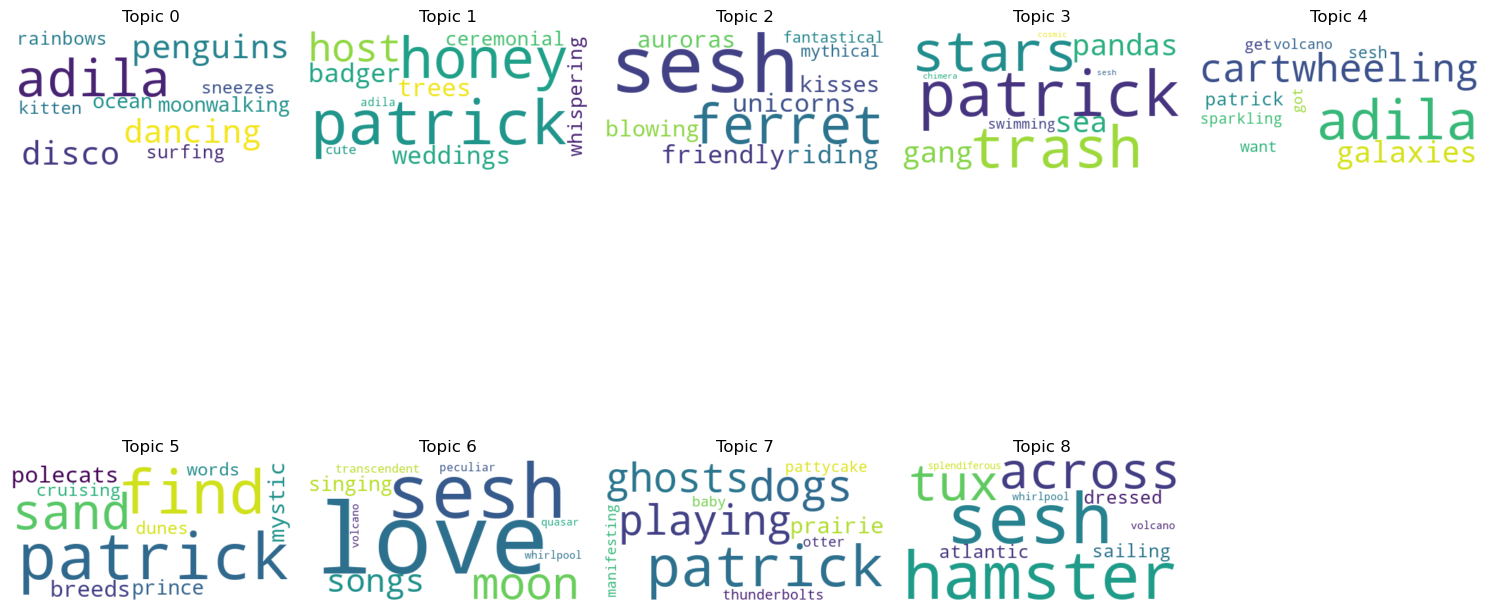

-----------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---model: m2auto | num_topics 9------------------------------------------------------------------------------


/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matpl

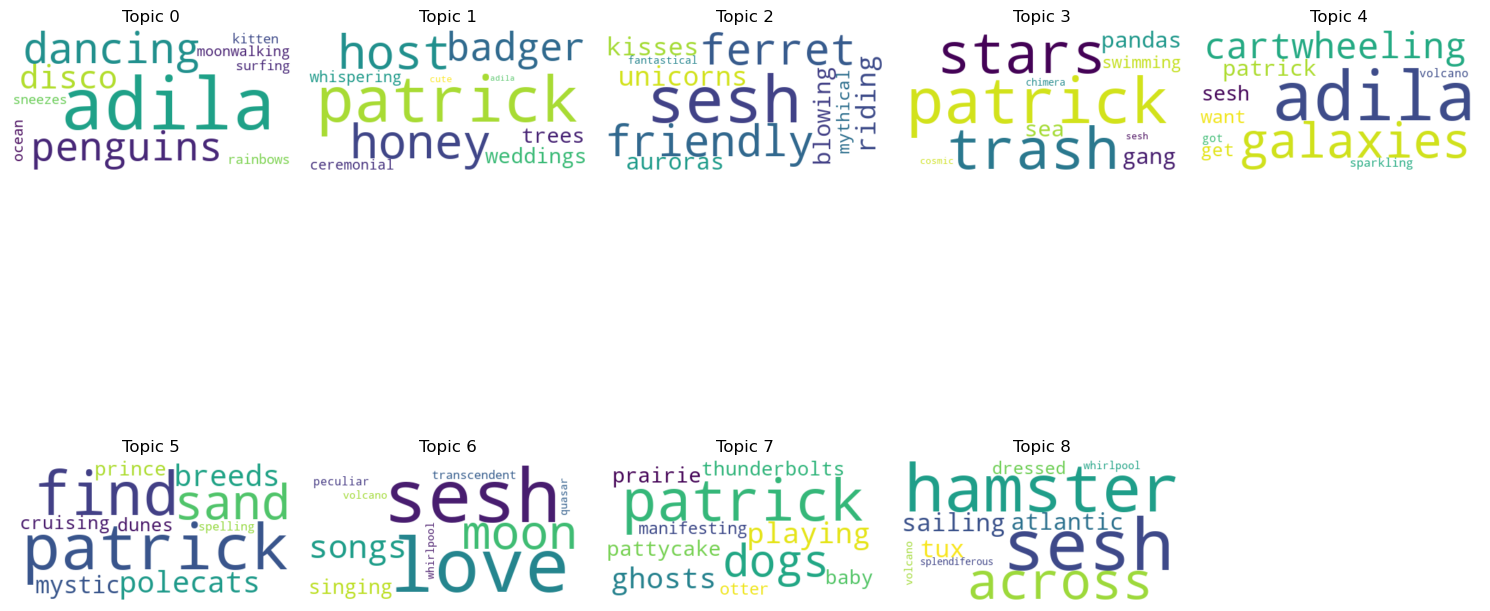

-----------------------------------------------------------------------------------------------------------------


In [44]:
from models.viz.utils import generate_word_clouds
for num_topics in [9]: 
    for model_name in ["m2symmetric", "m2auto"]:
        print(f"------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
        print(f"---model: {model_name} | num_topics {num_topics}------------------------------------------------------------------------------")
        logic = ((df_coherence["model_name"]==model_name) & (df_coherence['num_topics']==num_topics))
        tmp_model = df_coherence[logic]['model'].values[0]
        generate_word_clouds(tmp_model, clouds_per_row=5)
        print(f"-----------------------------------------------------------------------------------------------------------------")


#### Reflections on pyLDAvis for m2symmetric
Reflections:
1. Varing `num_topics` and considering the Intertopic Distance Map for various versions of `m2symmetric` & `m2auto`, the tradeoff in a lower coherence score at 4 topics vs a higher score at 9 is the overlap (ie. the topics share more words).
2. Using `num_toipcs = 4` offers a superb distance between relatively full topics.
   * the distance shows that the topic bubble do not overlap so each topic is more distinctly defined and do not share many of the same words. 
   * the size of the bubbles is also relatively equal meaning that the topics are somewhat equal in the amount of words they each pull from the dataset.
3. Visually, `num_topics=4` has advantages.
   * The topics are roughly `Sesh`, `Patrick`, `Adila` and the 4th is their overlap.
4. Investigating the relevance and sliding lambda down to 0.6:
   *  With a little more lift, the difference between `num_topics=4` and `num_topics=9` is that the added topics provide an view into pairings between two individuals from the set of three names, which is not availble at `num_topics=4`.
5. Allowing for more broadly defined topics at `num_topics=4` might clarify the differences between the three and offer one clarity between what all three share, but it misses the coupling available at `num_topics=9`. 

In [45]:
import joblib 
import gensim 
model_name = 'm2symmetric9'
method = 'm2'
alpha = 'symmetric'
time_str = '20240317-132003'
num_topics = 9
df_data = pd.DataFrame(joblib.load(f'data/df_data_baseline_{time_str}.joblib'))
logic = ((df_data["method"]==method) & (df_data['num_topics']==num_topics) & (df_data['alpha'] == 'symmetric'))
df_data[logic]

,num_topics,method,alpha,coherence_scores_umass,coherence_scores_cv,model
27,9,m2,symmetric,-9.328938,0.443953,"LdaModel<num_terms=740, num_topics=9, decay=0...."


In [46]:
method = 'm2'
alpha = 'symmetric'
time_str = '20240317-132003'
num_topics = 9

lda_model = gensim.models.LdaModel.load(f'data/lda/lda_{method}{alpha}{str(num_topics)}_{time_str}.model')
train_corpus = joblib.load(f'data/lda/train_corpus_m2_{time_str}.joblib')
dictionary = joblib.load(f'data/lda/dictionary_m2_{time_str}.joblib')

df_data = pd.DataFrame(joblib.load(f'data/df_data_baseline_{time_str}.joblib'))
logic = ((df_data["method"]==method) & (df_data['num_topics']==num_topics) & (df_data['alpha'] == 'symmetric'))
df_data[logic]

,num_topics,method,alpha,coherence_scores_umass,coherence_scores_cv,model
27,9,m2,symmetric,-9.328938,0.443953,"LdaModel<num_terms=740, num_topics=9, decay=0...."


#### Reviewing Baseline Model

In [47]:
from models.viz.utils import get_pyLDAvis_input
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()

lda_model, train_corpus, dictionary, coherence_scores_umass, coherence_scores_cv = get_pyLDAvis_input(method = 'm2', alpha = 'symmetric', time_str = '20240317-132003', num_topics = 9)

print("------------------------------------")
print(f"coherence score (u_mass): {coherence_scores_umass}")
print(f"coherence score (c_v): {coherence_scores_cv}")
print("------------------------------------")
lda_display = gensimvis.prepare(lda_model, train_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

------------------------------------
coherence score (u_mass): -9.328938035061189
coherence score (c_v): 0.4439532208641127
------------------------------------
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) en

#### Reviewing a saved alternative model

In [48]:
from models.viz.utils import get_pyLDAvis_input
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()

lda_model, train_corpus, dictionary, coherence_scores_umass, coherence_scores_cv = get_pyLDAvis_input(method = 'm2', alpha = 'symmetric', time_str = '20240319-232213', num_topics = 9)

print("------------------------------------")
print(f"coherence score (u_mass): {coherence_scores_umass}")
print(f"coherence score (c_v): {coherence_scores_cv}")
print("------------------------------------")
lda_display = gensimvis.prepare(lda_model, train_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)


------------------------------------
coherence score (u_mass): -10.166007975703659
coherence score (c_v): 0.4453037800516097
------------------------------------


#### Reviewing a new alternative model

In [49]:
%matplotlib inline
import pyLDAvis
from models import build_m2_models
from models.viz.utils import get_replaced_tweets
lda_model, train_corpus, dictionary, df_data = build_m2_models.main(get_replaced_tweets(), num_topics=9)

print("------------------------------------")
print(f"{df_data['coherence_scores_umass']}")
print(f"{df_data['coherence_scores_cv']}")
print("------------------------------------")
lda_display = gensimvis.prepare(lda_model, train_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Consider Original Tweets
These original tweets scored using the baseline model with `num_topics = 9` are examples of the topic's content. The percentages of the topic distribution across the umique tweet set is included as well.

In [50]:
from collections import defaultdict
#import gensim
#import joblib
from models.LDA_coherence import preprocess_text_m2
from models.viz.utils import get_replaced_tweets, create_mapping, print_original_tweets_for_topics

unique_tweet_text = joblib.load("data/lda/unique_tweet_texts_m2_20240317-132003.joblib")
lda_model = gensim.models.LdaModel.load("data/lda/lda_m2symmetric9_20240317-132003.model")
dictionary = joblib.load("data/lda/dictionary_m2_20240317-132003.joblib")

mapping = create_mapping(unique_tweet_text, get_replaced_tweets(), preprocess_text_m2)
print_original_tweets_for_topics(lda_model, unique_tweet_text, mapping, dictionary)

-------------------------------------------------------------
ORIGINAL tweets with their topic label, probability, and percentage of unique tweets:
-------------------------------------------------------------
Topic: 7
ORIGINAL tweet: RT @BabyAnimalPics: half captivating whirlwind playing pattycake with the ghosts of prairie dogs, half Patrick https://t.co/86vpNGZ9mr
Topic label: 7 Probability: 0.9012277722358704
Percentage of unique tweets: 12.88%
-------------------------------------------------------------
Topic: 0
ORIGINAL tweet: I had a dream last night that there was a pet store near my house with a Patrick puppy and I cried when they let me hold it.
Topic label: 0 Probability: 0.8435250520706177
Percentage of unique tweets: 18.41%
-------------------------------------------------------------
Topic: 1
ORIGINAL tweet: RT @BabyAnimalPics: half frenetic tornado whispering to trees that host ceremonial honey badger weddings, half Patrick https://t.co/86vpNGZ9mr
Topic label: 1 Probabi

### BASELINE Modeling Summary & Next Steps
1. Choosing num_toipcs = 4 or 9 for the baseline model results in topics that are tough to interpret; possibly indicated by the low `c_v` scores.
2. Multiple runs of the this LDA process showed varied values for the coherence scores, none of which were above 45% for for `c_v`. 
1. The pyLDAvis Intertopic Distance Map shifts significantly across LDA models even for the same value of `n_topics` (see the above examples both pinned at `n_topics=9`)
2. The meaning of these topics doesn't emerge, which could surely be at the source of how this dataset is created.
   * LDA doesn't use the context of the word for developing the topic.
   * BERT and Word2Vec might be worth exploring to see if the more rich embeddings are useful.
   * CorEx could be explored as a quick comparison.  
### BASELINE final model selection 
* `lda_model = LdaModel.load('data/lda/m2symmetric9_20240317-132003.joblib')`

# Part III: Compare BASELINE to selected modeling methods 

## CorEx
[Link to comparison chart here](https://vega.github.io/editor/#/gist/78a49c0233f821103a8917891f760432/lda_coherence_scores.json).

The author wants to play with the anchored topics (semi-supervised) and tinker with the hierarchical representation of topics; however, this project is simply a demo. So a quick model is going to be built and a short analysis made using our baseline metric for coherence scores. For future play though, the author of CorEx, Ryan J. Gallagher, has some great details on his [github site](https://ryanjgallagher.github.io/code/corex/example) and his [jupyter notebook](https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb). 

In [51]:
from models import corex_m1
from models.viz.utils import get_replaced_tweets
from models.LDA_coherence import preprocess_text_m2

num_topic_range = (3, 12)
models, vectorizers, topic_words_list, tweets = corex_m1.get_corex_models(get_replaced_tweets(), preprocess_text_m2, num_topic_range)
df_data = corex_m1.get_coherence_plot_data(models, vectorizers, topic_words_list, tweets)

NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Su

In [52]:
import pandas as pd
df_comp = pd.concat([pd.DataFrame(df_data),df_coherence[df_coherence.model_name=="m2symmetric"].loc[:,['c_v','u_mass','num_topics','model_name']]])

In [53]:
%%capture output

comp_coherence_chart = build_multiline_altair(pd.DataFrame(df_comp))


In [54]:
comp_coherence_chart

/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/altair/utils/schemapi.py:118: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature request (on referencing) if you are missing an API for the kind of customization you need.
  resolver = jsonschema.RefResolver.from_schema(rootschema)
/Users/lehman/opt/anaconda3/envs/tweet_topic_modeling_/lib/python3.10/site-packages/altair/utils/schemapi.py:118: DeprecationWarning: jsonschema.RefResolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization. A future release will remove RefResolver. Please file a feature r

alt.LayerChart(...)

In [55]:
num_topics = 6 # elbow of m2corex
index = num_topics - 3
corex_topic_model = models[index]
topic_words = topic_words_list[index]

In [56]:
topics = corex_topic_model.get_topics()
for n,word_list in enumerate(topic_words):
    if n==0:
        print("")
    print(f'topic {n}: ' + ', '.join(word_list))

NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices

topic 0: patrick, baby, manifesting, otter, trading, thunderbolts, pandas, gang, sea, stars
topic 1: adila, spelling, sky, fireflies, words, moonwalking, ocean, penguins, dancing, disco
topic 2: sesh, songs, singing, moon, ferret, friendly, riding, unicorns, auroras, blowing
topic 3: hamster, sailing, dressed, tux, atlantic, pattycake, prairie, ghosts, mystic, cruising
topic 4: got, wish, puppies, think, family, days, class, upper, seen, husky
topic 5: old, like, guide, care, health, training, hair, look, hes, absolute


# Summary
* The `m2corex` model does not seem to outperform `m2symmetric` for any specific range of values on the coherence metric. 

* The same issues with topic meaning seem to emerge; what doees this set of words mean collectively?

* Baseline is still the best choice presently.

# Conclusion
What topics exist in these tweets? 

* Topic 1: Patrick has a side gig as a honey badger whisperer at weddings
* Topic 2: Patrick is on a mission to find sand possibly using polecats and princes as guides.
* Topic 3: Sesh absolutely loves songs about the moon and transcendent whirlpools near volcanos.
* Topic 4: Adila's oceanside discos involve dancing penguins, kitten sneezes, and the occasional rainbow.
* Topic 5: Baby Patrick playing patty cake with ghosts is super popular alongside his Thor like of qualities of manifesting thunderbolts.
* Topic 6: Sesh is preparing to set sail across the Atlantic and finds it imperative to bring a tuxedo wearing hamster.
* Toipc 7: Sesh has a ridable unicorn that he enjoys the most when he brings his friendly ferret.
* Topic 8: (combined) Adila, Sesh, and Patrick are all into gazing upwards towards the stars as long as it involves a view of galaxies, auroras, or trash pandas.

This list is not exhaustive but offers some insight into the data.

# Next Steps
1. Explore CorEx's anchor topics and hierarchical representation potentially build a model with a higher coherence score than Baseline.
2. BERT seems to need more resources. Potentially spin up a larger machine.
3. Word2Vec needs a trial. 

# Appendix
Where code dies. 

### BERT Topic Modeling | KERNEL DIES <---
To potentially improve the topic modeling, the context rich embeddings of BERT were intented to be explored. 

### Install

* `pip install bertopic`

### resource constraint 
* BERT does not seem to run locally (for the author). The most basic examples kill the kernel.  

In [57]:
run = False
if run: 
    from bertopic import BERTopic
    from sklearn.datasets import fetch_20newsgroups
    
    docs = fetch_20newsgroups(subset='train',  remove=('headers', 'footers', 'quotes'))['data']
    
    topic_model = BERTopic()
    topics, probs = topic_model.fit_transform(docs)
    
    print(topic_model.get_topic_info(0))

In [58]:
run = False
if run: 
    import torch
    from transformers import BertTokenizer, BertModel
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    bert_model = BertModel.from_pretrained(model_name).eval()
    
    # Tokenize and embed tweets using BERT
    bert_embeddings = tokenize_and_embed_tweets(tokenizer, bert_model, preprocessed_texts)
    
    # Convert BERT embeddings to a format suitable for LDA
    flattened_bert_embeddings = [emb.flatten() for emb in bert_embeddings]

### tinkering w/ Corex

In [59]:
run = False
if run: 
    from graphviz import Digraph
    %matplotlib inline
    vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')
    
    print(np.mean(topic_model.log_z, axis=0))
    print(topic_model.tcs)
    
    # Train a second layer to the topic model
    tm_layer2 = ct.Corex(n_hidden=10)
    tm_layer2.fit(topic_model.labels);
    
    # Train a third layer to the topic model
    tm_layer3 = ct.Corex(n_hidden=1)
    tm_layer3.fit(tm_layer2.labels);
    
    vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')
    vt.vis_rep(topic_model, column_label=words, prefix='corex_viz')